# Welcome to my Kernel ! 

**About the Kernel**

1. Intial versions (Ver 1 to 9) -  Basic EDA and Vanila ANN
2. Versions 9 - Word Embeddings with GLOVE 
3. Version 10 to 15 - BERT (my best model so far)
4. Version 16 to 19 - CNN model
5. Version 20 onwards - n-gram CNN model

# Introduction

This particular challenge is perfect for data scientists looking to get started with Natural Language Processing.

Competition Description
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. 

Take an example:
The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import xticks
from nltk.corpus import stopwords
import nltk
import re
from nltk.stem import WordNetLemmatizer
import string
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import defaultdict
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
import tensorflow as tf
from sklearn.metrics import f1_score
from wordcloud import WordCloud,STOPWORDS
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from keras.preprocessing.sequence import pad_sequences
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding,Activation,Dropout
from keras.layers import Conv1D,MaxPooling1D,GlobalMaxPooling1D,LSTM

Using TensorFlow backend.


In [2]:
# load train and test datasets
train= pd.read_csv('../input/nlp-getting-started/train.csv')
test=pd.read_csv('../input/nlp-getting-started/test.csv')

In [3]:
# check the no. of rows and columns in the dataset
train.shape, test.shape

((7613, 5), (3263, 4))

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train.isnull().sum().sort_values(ascending = False)

location    2533
keyword       61
target         0
text           0
id             0
dtype: int64

We can see a lots of null values for "keyword" and "location" columns

# Exploratory Data Analysis

I have written few functions to perform EDA.

In [6]:
# function to draw bar plot
def draw_bar_plot(category,length,xlabel,ylabel,title,sub):
    plt.subplot(2,2,sub)
    plt.bar(category, length,color = 'grbkymc')
    plt.legend()
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.title(title, fontsize=15)
    #plt.show()

In [7]:
# function to draw histogram
def draw_hist(xlabel, ylabel,title,target,sub,color):
    plt.subplot(1,2,sub)
    plt.hist(train[train.target==target]["length"],color = color)
    plt.title(title,fontsize=25)
    plt.xlabel(xlabel,fontsize=15)
    plt.ylabel(ylabel,fontsize=15)
    plt.ylim(0,1200)
    plt.grid()

Let's write a small function to draw graphs for stopwords and punctuations present in the tweets

In [8]:
# function to draw graphs for stopwords and punctuations
def draw_bar_n_plot(data,title):
# lets visualize the top 10 stop words
    x,y=zip(*data)

    plt.figure(figsize = (25,10))
    plt.subplot(1,2,1)
    plt.bar(x,y,color='grbkymc')
    plt.title("Top 10 "+ title,fontsize=25)
    plt.xlabel(title,fontsize=15)
    plt.ylabel("Count",fontsize=15)
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(x,y,'g')
    plt.title("Top 10 "+ title,fontsize=25)
    plt.xlabel(title,fontsize=15)
    plt.ylabel("Count",fontsize=15)
    plt.grid()

In [9]:
# check class distribution

print("No. of Real Disaster Tweets (Target = 1):",len(train[train["target"]==1]))
print("No. of Fake Disaster Tweets (Target = 0):",len(train[train["target"]==0]))

No. of Real Disaster Tweets (Target = 1): 3271
No. of Fake Disaster Tweets (Target = 0): 4342


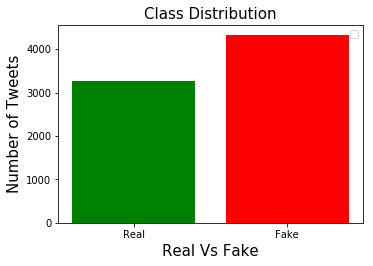

In [10]:
# lets visualize the class distribution
plt.figure(figsize = (12,8))
draw_bar_plot(["Real","Fake"],[len(train[train.target==1]), len(train[train.target==0])],"Real Vs Fake","Number of Tweets","Class Distribution",1)

**We have a balanced dataset, which is good**

In [11]:
# we will now check the length of "real disaster" vs lenght of "fake disaster" tweets
# lets first add a new field to the dataset called "length"
def length(text):    
    return len(text)

train["length"]= train.text.apply(length)

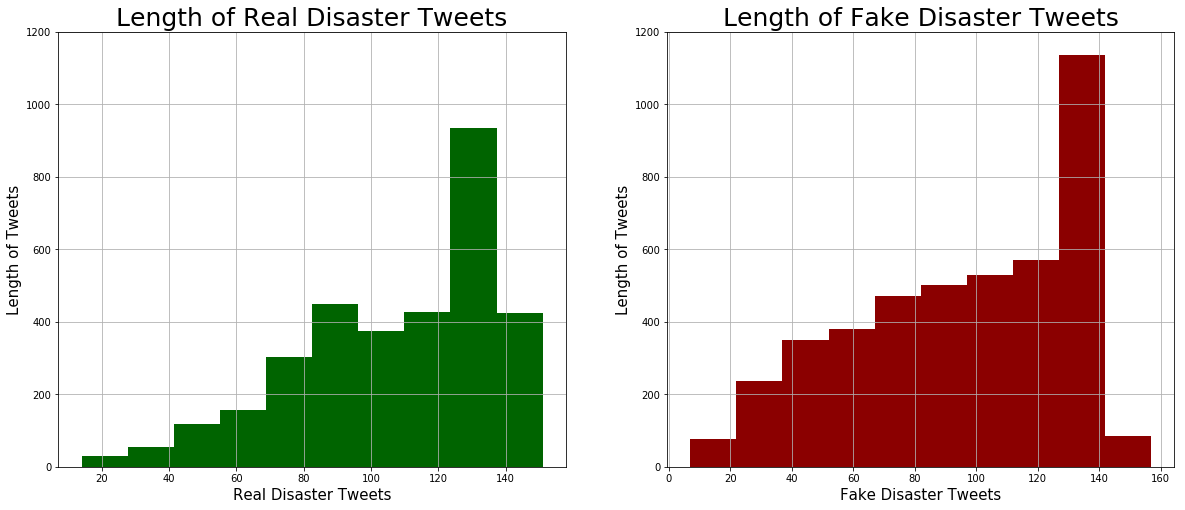

In [12]:
# lets see the distribution of length of tweets real vs fake

plt.figure(figsize = (20,8))
draw_hist("Real Disaster Tweets","Length of Tweets","Length of Real Disaster Tweets",1, 1,"darkgreen")
draw_hist("Fake Disaster Tweets","Length of Tweets","Length of Fake Disaster Tweets",0, 2,"darkred")


**Above graphs show that length of real as well as fake tweets varies in the same range 0 to 150 approx**

target
1    108.113421
0     95.706817
Name: length, dtype: float64


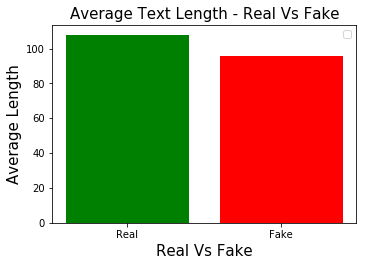

In [13]:
# lets check the average lenght of real vs fake tweets
print(train.groupby("target").mean()["length"].sort_values(ascending = False))

# lets visualize the class distribution
plt.figure(figsize = (12,8))
draw_bar_plot(["Real","Fake"],[train[train.target==1].mean()["length"], train[train.target==0].mean()["length"]],"Real Vs Fake","Average Length","Average Text Length - Real Vs Fake",1)

**Average length is also almost same for both the cases, so, we can conclude that length of the tweets has nothing to do with its real/fake categorization**

In [14]:
# lets drop the column
train.drop("length",1,inplace=True)

# STOPWORDS & PUNCTUATIONS

1. "stop words" usually refers to the most common words in a language. for example 'a', 'the' etc. These words are essential parts of any language but do not add anything significant to the meaning of a word.

2. punctuation marks are marks such as a full stop, comma, or question mark, used in writing to separate sentences and their elements and to clarify meaning.

### Stopwords present in the whole dataset

In [15]:
#lets save stopwords in a variable
stop = list(stopwords.words("english"))

In [16]:
# stopwords present in the whole dataset
sw = []
for message in train.text:
    for word in message.split():
        if word in stop:
            sw.append(word)


# lets convert the list to a dictinoary which would contain the stop words and their frequency
wordlist = nltk.FreqDist(sw)
# lets save the 10 most frequent stopwords
top10 = wordlist.most_common(10)

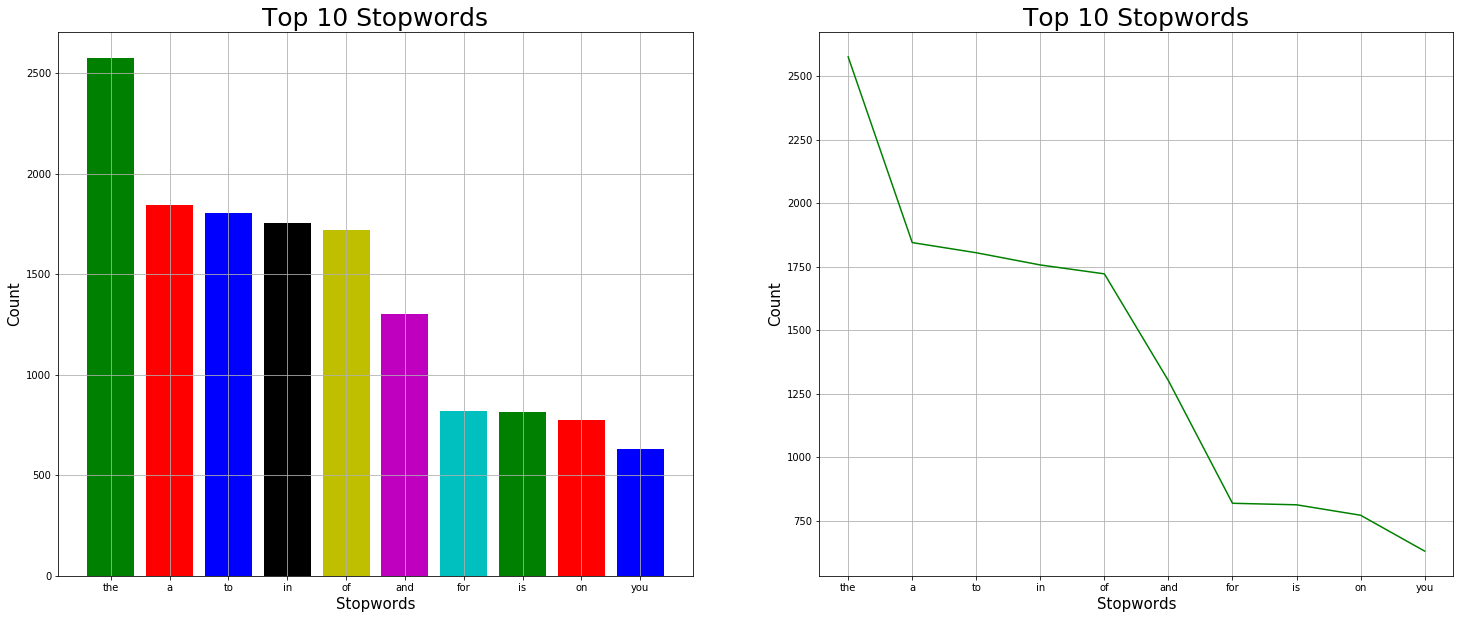

In [17]:
# Graphs for top 10 stopwords present in all the tweets
draw_bar_n_plot(top10,"Stopwords")

### Punctuations present in the whole dataset

In [18]:
# save list of punctuation/special characters in a variable
punctuation = list(string.punctuation)

In [19]:
# punctuations present in all the tweets 
pun = []
for message in train.text:
    for word in message.split():
        if word in punctuation:
            pun.append(word)


# lets convert the list to a dictinoary which would contain the punctuations and their frequency
wordlist = nltk.FreqDist(pun)
# lets save the 10 most frequent stopwords
top10 = wordlist.most_common(10)

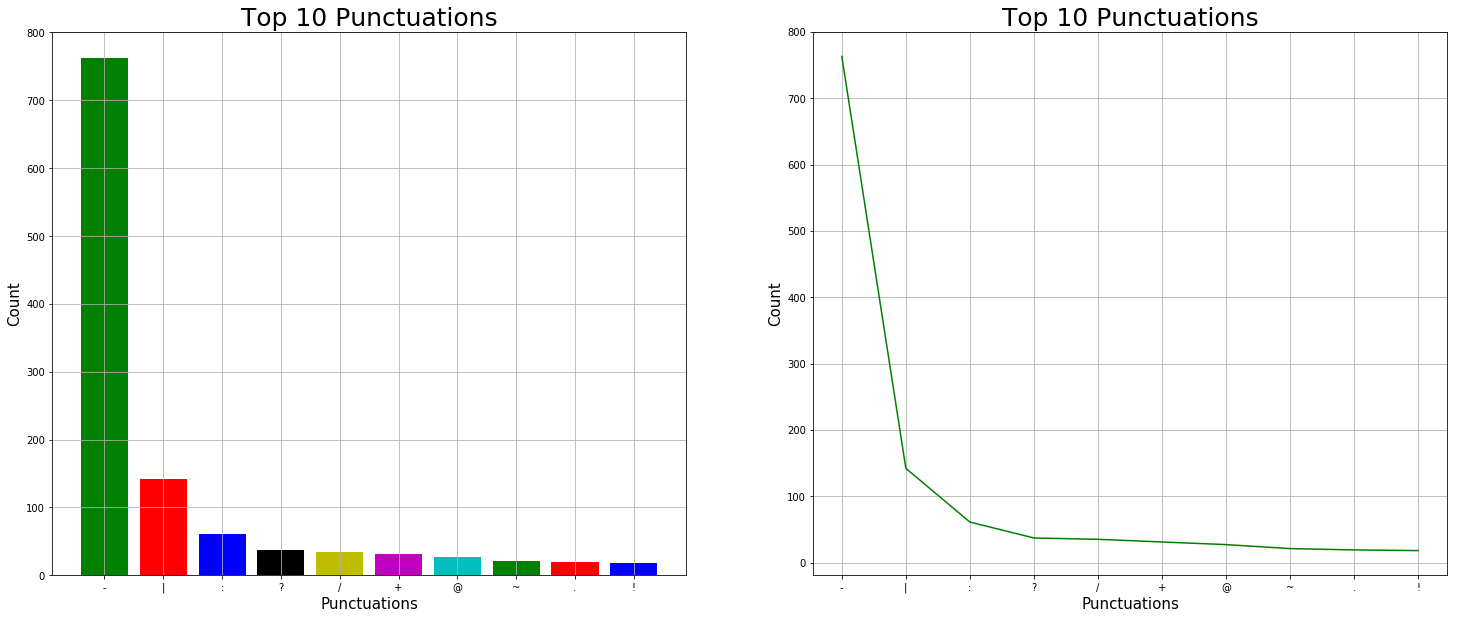

In [20]:
# draw graphs for top10 Punctuations
draw_bar_n_plot(top10,"Punctuations")

### Stopwords & Punctuations present in real vs fake tweets

In [21]:
# Let's check stop words and punctuations in "Real Disaster Tweets"
stop_real = []
pun_real  = []
for message in train[train.target==1]["text"]:
    for word in message.split():
        if word in stop:
            stop_real.append(word)
        if word in punctuation:
            pun_real.append(word)


# lets convert the list to a dictinoary which would contain the stop word and its frequency
stop_real_wordlist = nltk.FreqDist(stop_real)
pun_real_wordlist =  nltk.FreqDist(pun_real)

# lets save the 10 most frequent stopwords
stop_real_top10 = stop_real_wordlist.most_common(10)
pun_real_top10  = pun_real_wordlist.most_common(10)

In [22]:
# Let's check "Fake Disaster Tweets" and create a list of stop words and punctuations
stop_fake = []
pun_fake  = []
for message in train[train.target==0]["text"]:
    for word in message.split():
        if word in stop:
            stop_fake.append(word)
        if word in punctuation:
            pun_fake.append(word)


# lets convert the list to a dictinoary which would contain the stop word and its frequency
stop_fake_wordlist = nltk.FreqDist(stop_fake)
pun_fake_wordlist =  nltk.FreqDist(pun_fake)

# lets save the 10 most frequent stopwords
stop_fake_top10 = stop_fake_wordlist.most_common(10)
pun_fake_top10  = pun_fake_wordlist.most_common(10)

**Lets visualize the top 10 stopwords and punctuations present in real and fake tweets** 

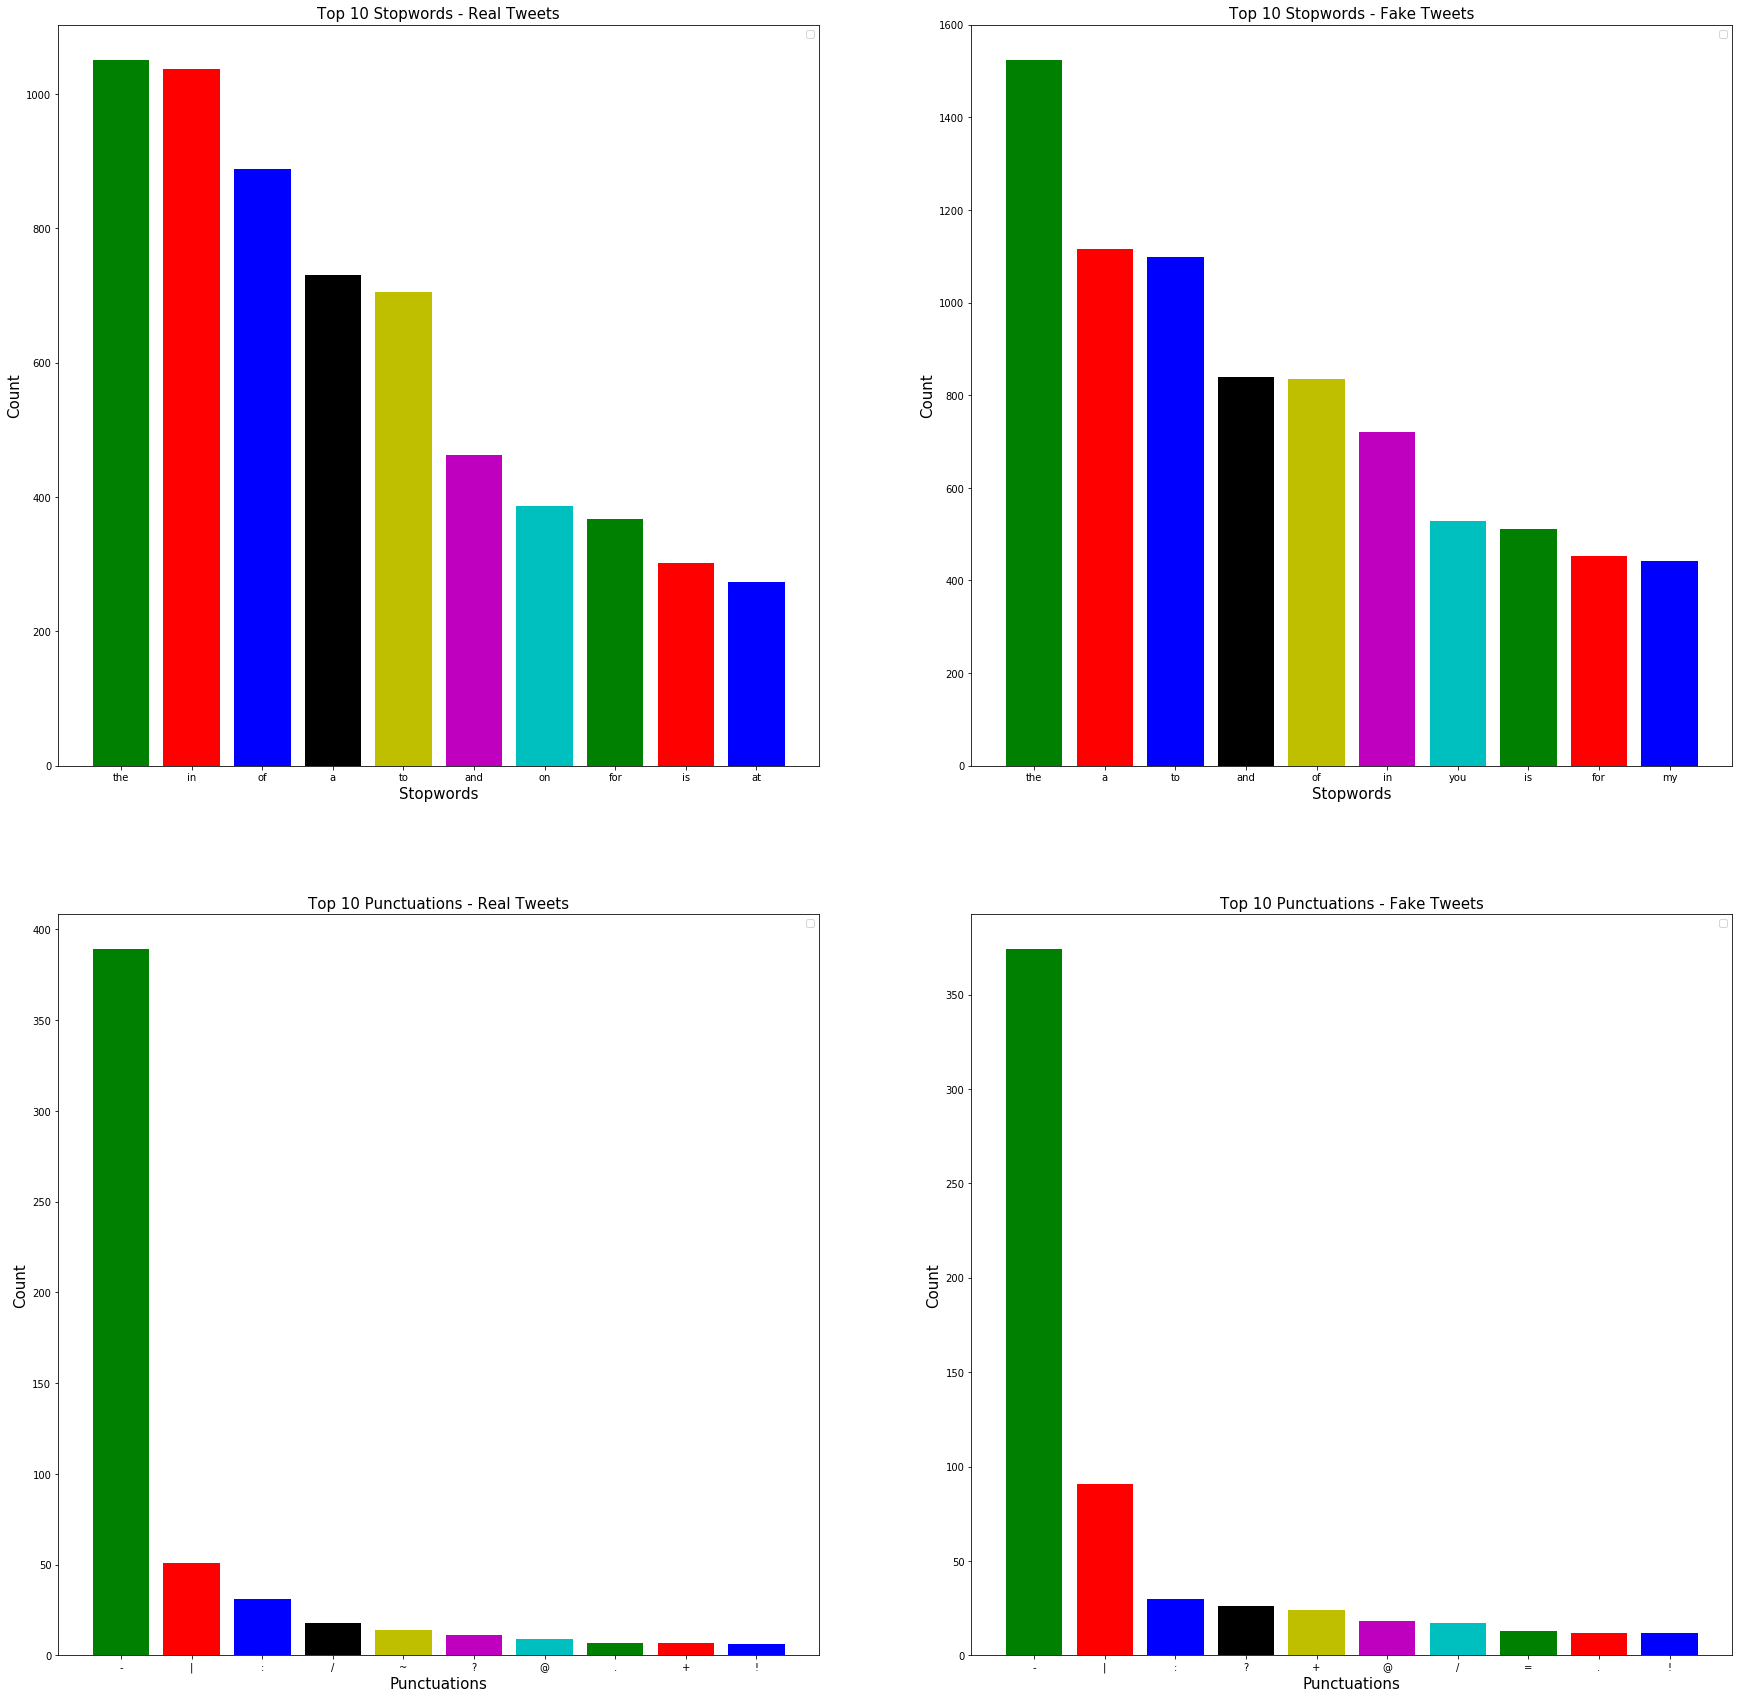

In [23]:
x_stop_real,y_stop_real=zip(*stop_real_top10)
x_pun_real, y_pun_real =zip(*pun_real_top10)

x_stop_fake,y_stop_fake=zip(*stop_fake_top10)
x_pun_fake, y_pun_fake=zip(*pun_fake_top10)


plt.figure(figsize = (30,30))
draw_bar_plot(x_stop_real,y_stop_real,"Stopwords","Count","Top 10 Stopwords - Real Tweets",1)
draw_bar_plot(x_stop_fake,y_stop_fake,"Stopwords","Count","Top 10 Stopwords - Fake Tweets",2)
draw_bar_plot(x_pun_real,y_pun_real,"Punctuations","Count","Top 10 Punctuations - Real Tweets",3)
draw_bar_plot(x_pun_fake,y_pun_fake,"Punctuations","Count","Top 10 Punctuations - Fake Tweets",4)

Nothing intuitive from the above graphs, no strong relation with real/fake disaster tweets

# Data Cleaning

In order to get accurate results from the predictive model, we need to remove these stop words & punctuations.

Apart from removing these stopwords & puncuations, we would also convert all the messages in lowercase so that words like "Go" & "go" can be treated as same word and not different words.

We will also convert the words to its lemma form (for example, lemma of word "running" would be run), converting words to their lemmas would also help improving the predictive power of our model.

We would also remove embedded special characters from the tweets, for example, #earthquake should be replaced by earthquake

We also need to remove the "URLs" from the tweets

And then finally we remove the digits from the tweets

Lets write a small function "preprocess" to achive all these tasks.

In [24]:
# create an object to convert the words to its lemma form
lemma = WordNetLemmatizer()

In [25]:
# lets make a combine list of stopwords and punctuations
sw_pun = stop + punctuation

In [26]:
# function to preprocess the messages
def preprocess(tweet):
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet) # removing urls 
    tweet = re.sub('[^\w]',' ',tweet) # remove embedded special characters in words (for example #earthquake)         
    tweet = re.sub('[\d]','',tweet) # this will remove numeric characters
    tweet = tweet.lower()
    words = tweet.split()  
    sentence = ""
    for word in words:     
        if word not in (sw_pun):  # removing stopwords & punctuations                
            word = lemma.lemmatize(word,pos = 'v')  # converting to lemma    
            if len(word) > 3: # we will consider words with length  greater than 3 only
                sentence = sentence + word + ' '             
    return(sentence)

In [27]:
# apply preprocessing functions on the train and test datasets
train['text'] = train['text'].apply(lambda s : preprocess(s))
test ['text'] = test ['text'].apply(lambda s : preprocess(s))

In [28]:
# function to remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [29]:
# applying the function on the train and the test datasets
train['text'] = train['text'].apply(lambda s : remove_emoji(s))
test ['text'] = test ['text'].apply(lambda s : remove_emoji(s))


# Vocabulary creation


Lets create our own vocabulary

In [30]:
# function to create vocab
from collections import Counter
def create_vocab(df):
    vocab = Counter()
    for i in range(df.shape[0]):
        vocab.update(df.text[i].split())
    return(vocab)



In [31]:
# concatenate training and testing datasets
master=pd.concat((train,test)).reset_index(drop=True)

# call vocabulary creation function on master dataset
vocab = create_vocab(master)

# lets check the no. of words in the vocabulary
len(vocab)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


16442

In [32]:
# lets check the most common 50 words in the vocabulary
vocab.most_common(50)


[('like', 560),
 ('fire', 534),
 ('bomb', 338),
 ('news', 299),
 ('people', 286),
 ('burn', 262),
 ('time', 254),
 ('kill', 253),
 ('make', 248),
 ('attack', 240),
 ('flood', 233),
 ('crash', 232),
 ('build', 231),
 ('emergency', 229),
 ('video', 228),
 ('come', 223),
 ('disaster', 220),
 ('take', 217),
 ('would', 214),
 ('body', 209),
 ('think', 204),
 ('police', 199),
 ('look', 193),
 ('know', 192),
 ('love', 190),
 ('watch', 188),
 ('home', 187),
 ('storm', 187),
 ('still', 181),
 ('train', 177),
 ('suicide', 177),
 ('live', 172),
 ('first', 170),
 ('collapse', 169),
 ('back', 164),
 ('scream', 164),
 ('california', 159),
 ('want', 156),
 ('drown', 152),
 ('cause', 151),
 ('need', 150),
 ('work', 149),
 ('today', 149),
 ('world', 148),
 ('nuclear', 148),
 ('hiroshima', 147),
 ('year', 143),
 ('full', 143),
 ('service', 142),
 ('destroy', 138)]

lets consider only those words which have appeared more than once in the corpus


In [33]:
# create the final vocab by considering words with more than one occurence
final_vocab = []
min_occur = 2
for k,v in vocab.items():
    if v >= min_occur:
        final_vocab.append(k)

In [34]:
# lets check the no. of the words in the final vocabulary
len(final_vocab)


6025

vocab size reduced drastically from 16k to 6k

Now lets apply this vocab on our train and test datasets, we will keep only those words in training and testing datasets which appear in the vocabulary

In [35]:
# function to filter the dataset, keep only words which are present in the vocab
def filter(tweet):
    sentence = ""
    for word in tweet.split():  
        if word in final_vocab:
            sentence = sentence + word + ' '
    return(sentence)

In [36]:
# apply filter function on the train and test datasets
train['text'] = train['text'].apply(lambda s : filter(s))
test ['text'] = test ['text'].apply(lambda s : filter(s))

In [37]:
# lets take a look at the update training dataset
train.text.head()

0               deeds reason earthquake allah forgive 
1                             forest fire near canada 
2    residents shelter place officer evacuation she...
3    people receive wildfires evacuation order cali...
4    send photo ruby alaska smoke wildfires pour sc...
Name: text, dtype: object

We have cleaned the datasets and have also created vocab, now lets perform n-gram analysis

# N-gram Analysis

n-gram is basically set of occurring words within given window so when

n=1 it is Unigram

n=2 it is bigram

n=3 it is trigram and so on

Now suppose machine try to understand the meaning of sentence "I have a lovely dog" than it will split sentences into specific chunk.

It will consider word one by one which is unigram so each word will be a gram.

"I", "have", "a" , "lovely" , "dog"

I will consider two word at a time so it will be biagram so each two djacent words will be biagram

"I have" , "have a" , "a lovely" , "lovely dog"

So like this machine will split sentences into small group of words to understand its meaning.

In [38]:
# lets create seperate datasets from real and fake tweets
real = train[train.target==1].reset_index()
fake = train[train.target==0].reset_index()

In [39]:
# function to create top 100 n-grams
def get_ngrams(data,n):
    all_words = []
    for i in range(len(data)):
        temp = data["text"][i].split()
        for word in temp:
            all_words.append(word)

    tokenized = all_words
    esBigrams = ngrams(tokenized, n)

    esBigram_wordlist = nltk.FreqDist(esBigrams)
    top100 = esBigram_wordlist.most_common(100)
    top100 = dict(top100)
    df_ngrams = pd.DataFrame(sorted(top100.items(), key=lambda x: x[1])[::-1])
    return df_ngrams

In [40]:
# function to visualize the top 100 n-grams in real and fake disaster tweets
def draw_barplots(real,fake,title):
    plt.figure(figsize = (40,80),dpi=100)

    plt.subplot(1,2,1)
    sns.barplot(y=real[0].values[:100], x=real[1].values[:100], color='green')
    plt.title("Top 100" + title + "in Real Tweets",fontsize=15)
    
    plt.subplot(1,2,2)
    sns.barplot(y=fake[0].values[:100], x=fake[1].values[:100],color='red')
    plt.title("Top 100" + title + "in Fake Tweets",fontsize=15)

### Unigrams

In [41]:
# lets create top 100 unigrams
real_unigrams = get_ngrams(real,1)
fake_unigrams = get_ngrams(fake,1)

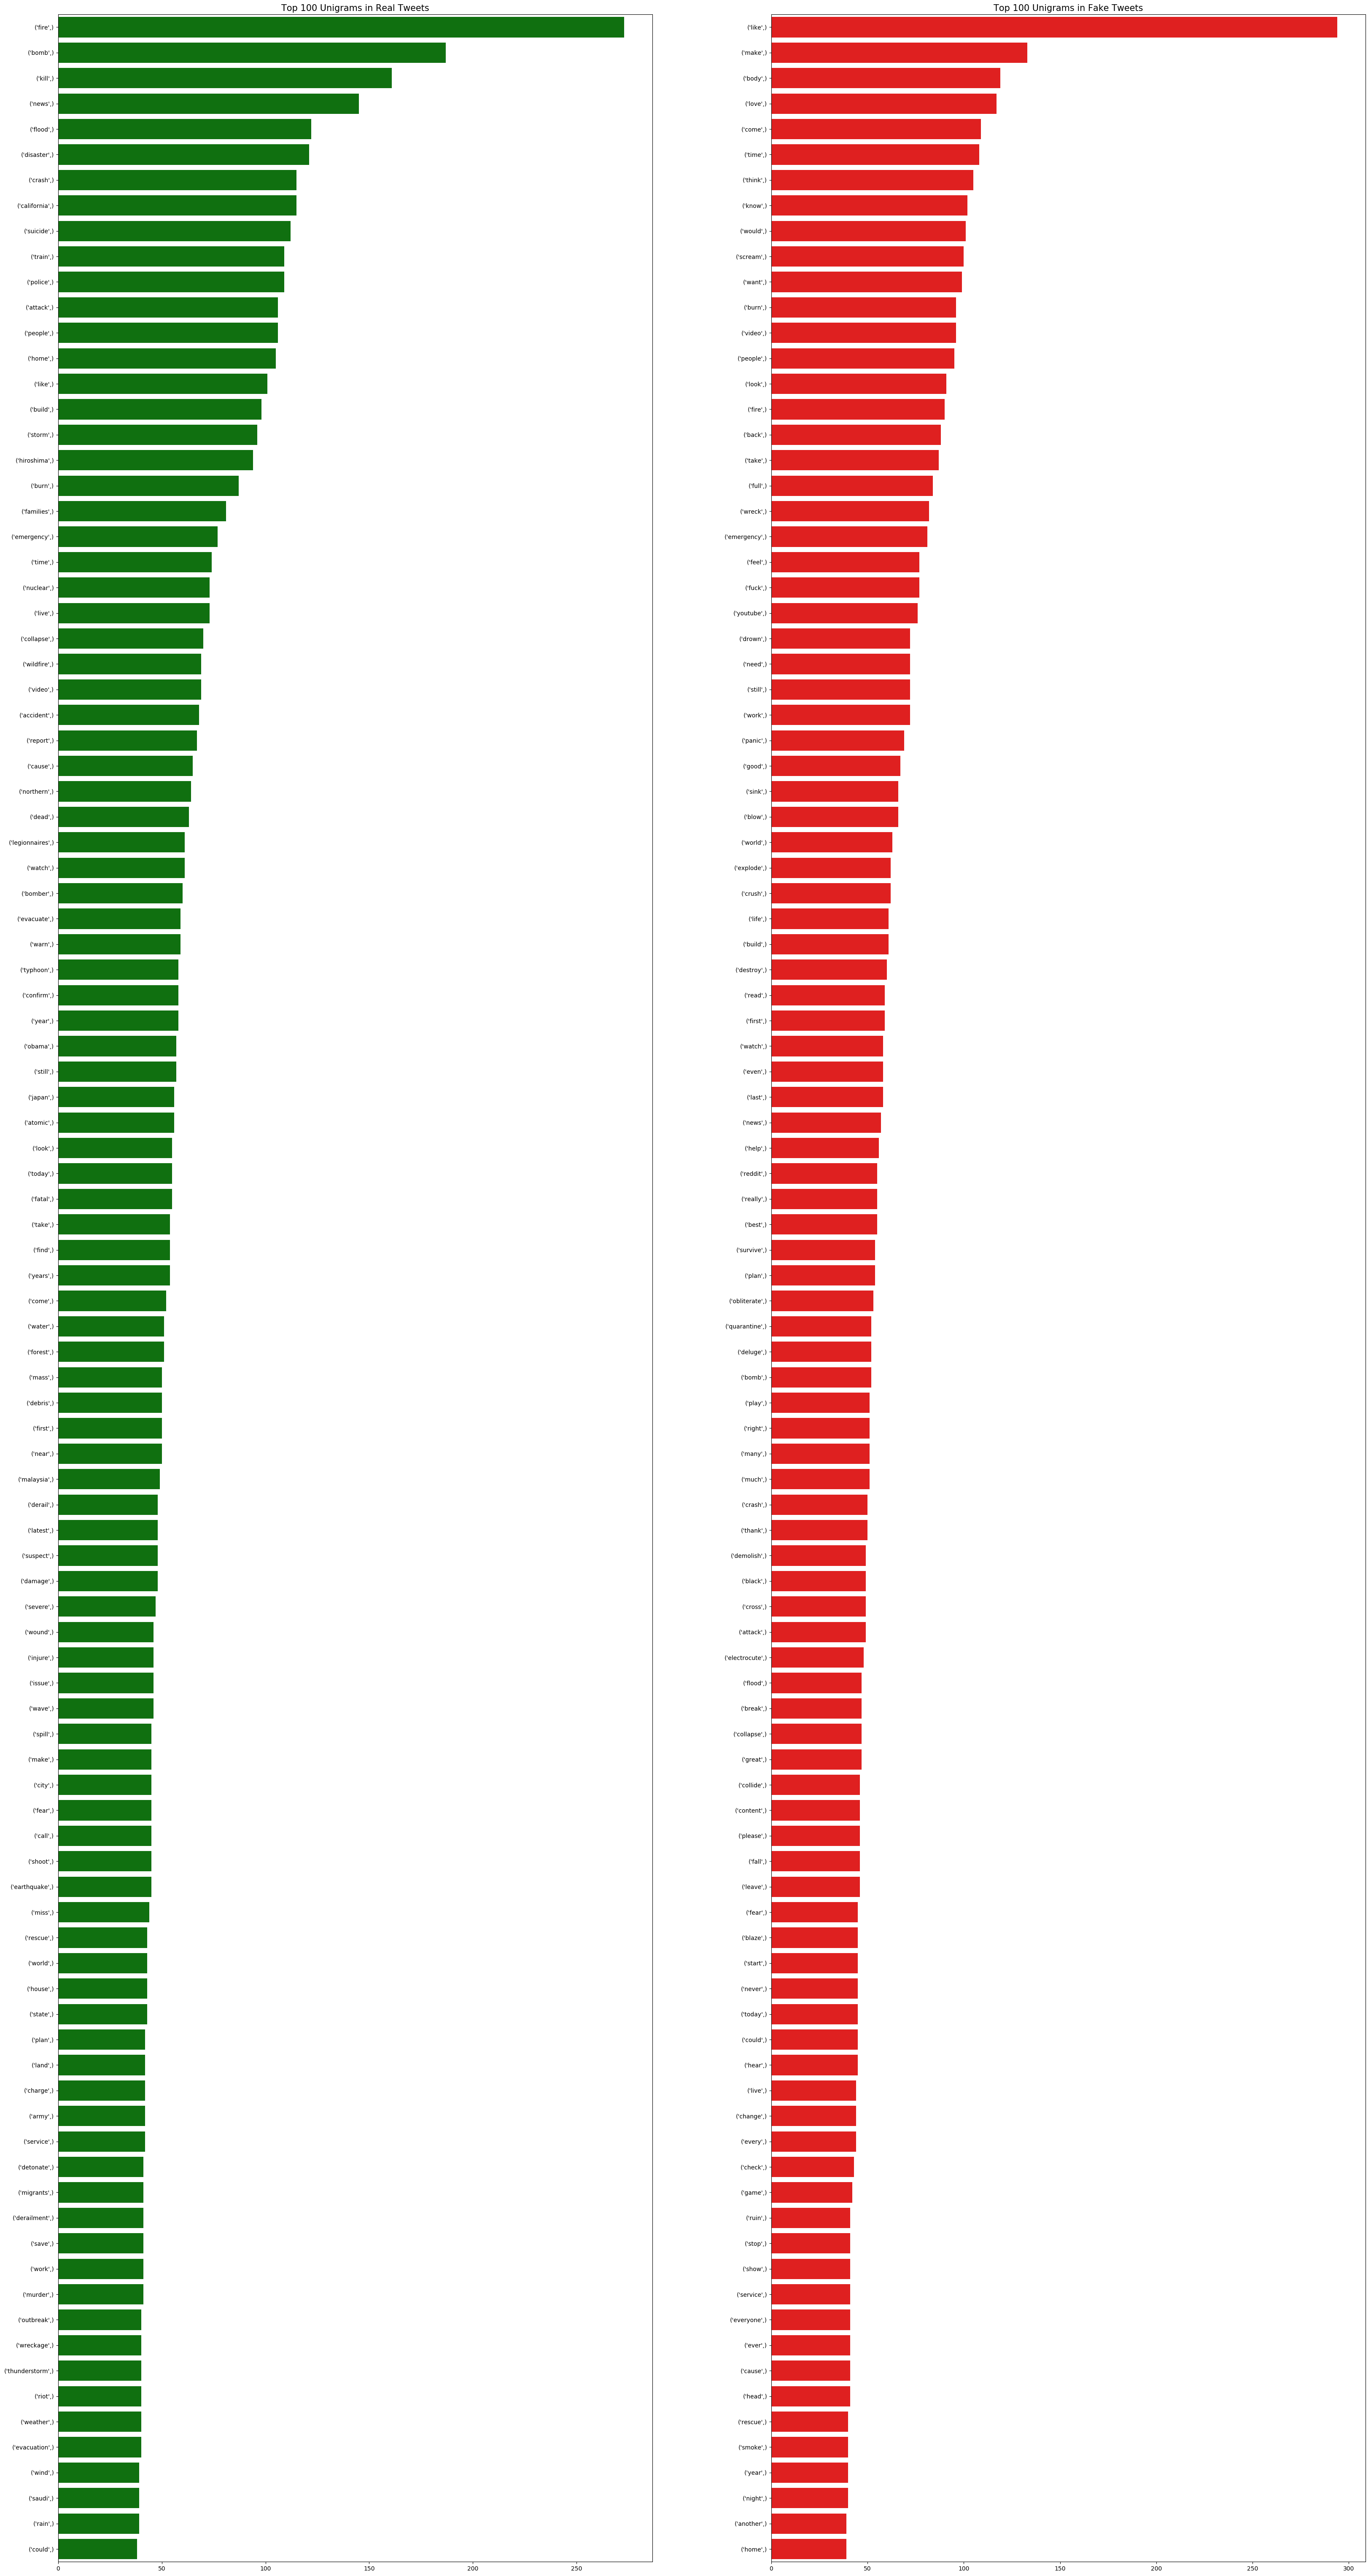

In [42]:
# lets visualize top 100 unigrams
draw_barplots(real_unigrams,fake_unigrams," Unigrams ")

### Bigrams

In [43]:
# lets create top 100 bigrams
real_bigrams = get_ngrams(real,2)
fake_bigrams = get_ngrams(fake,2)

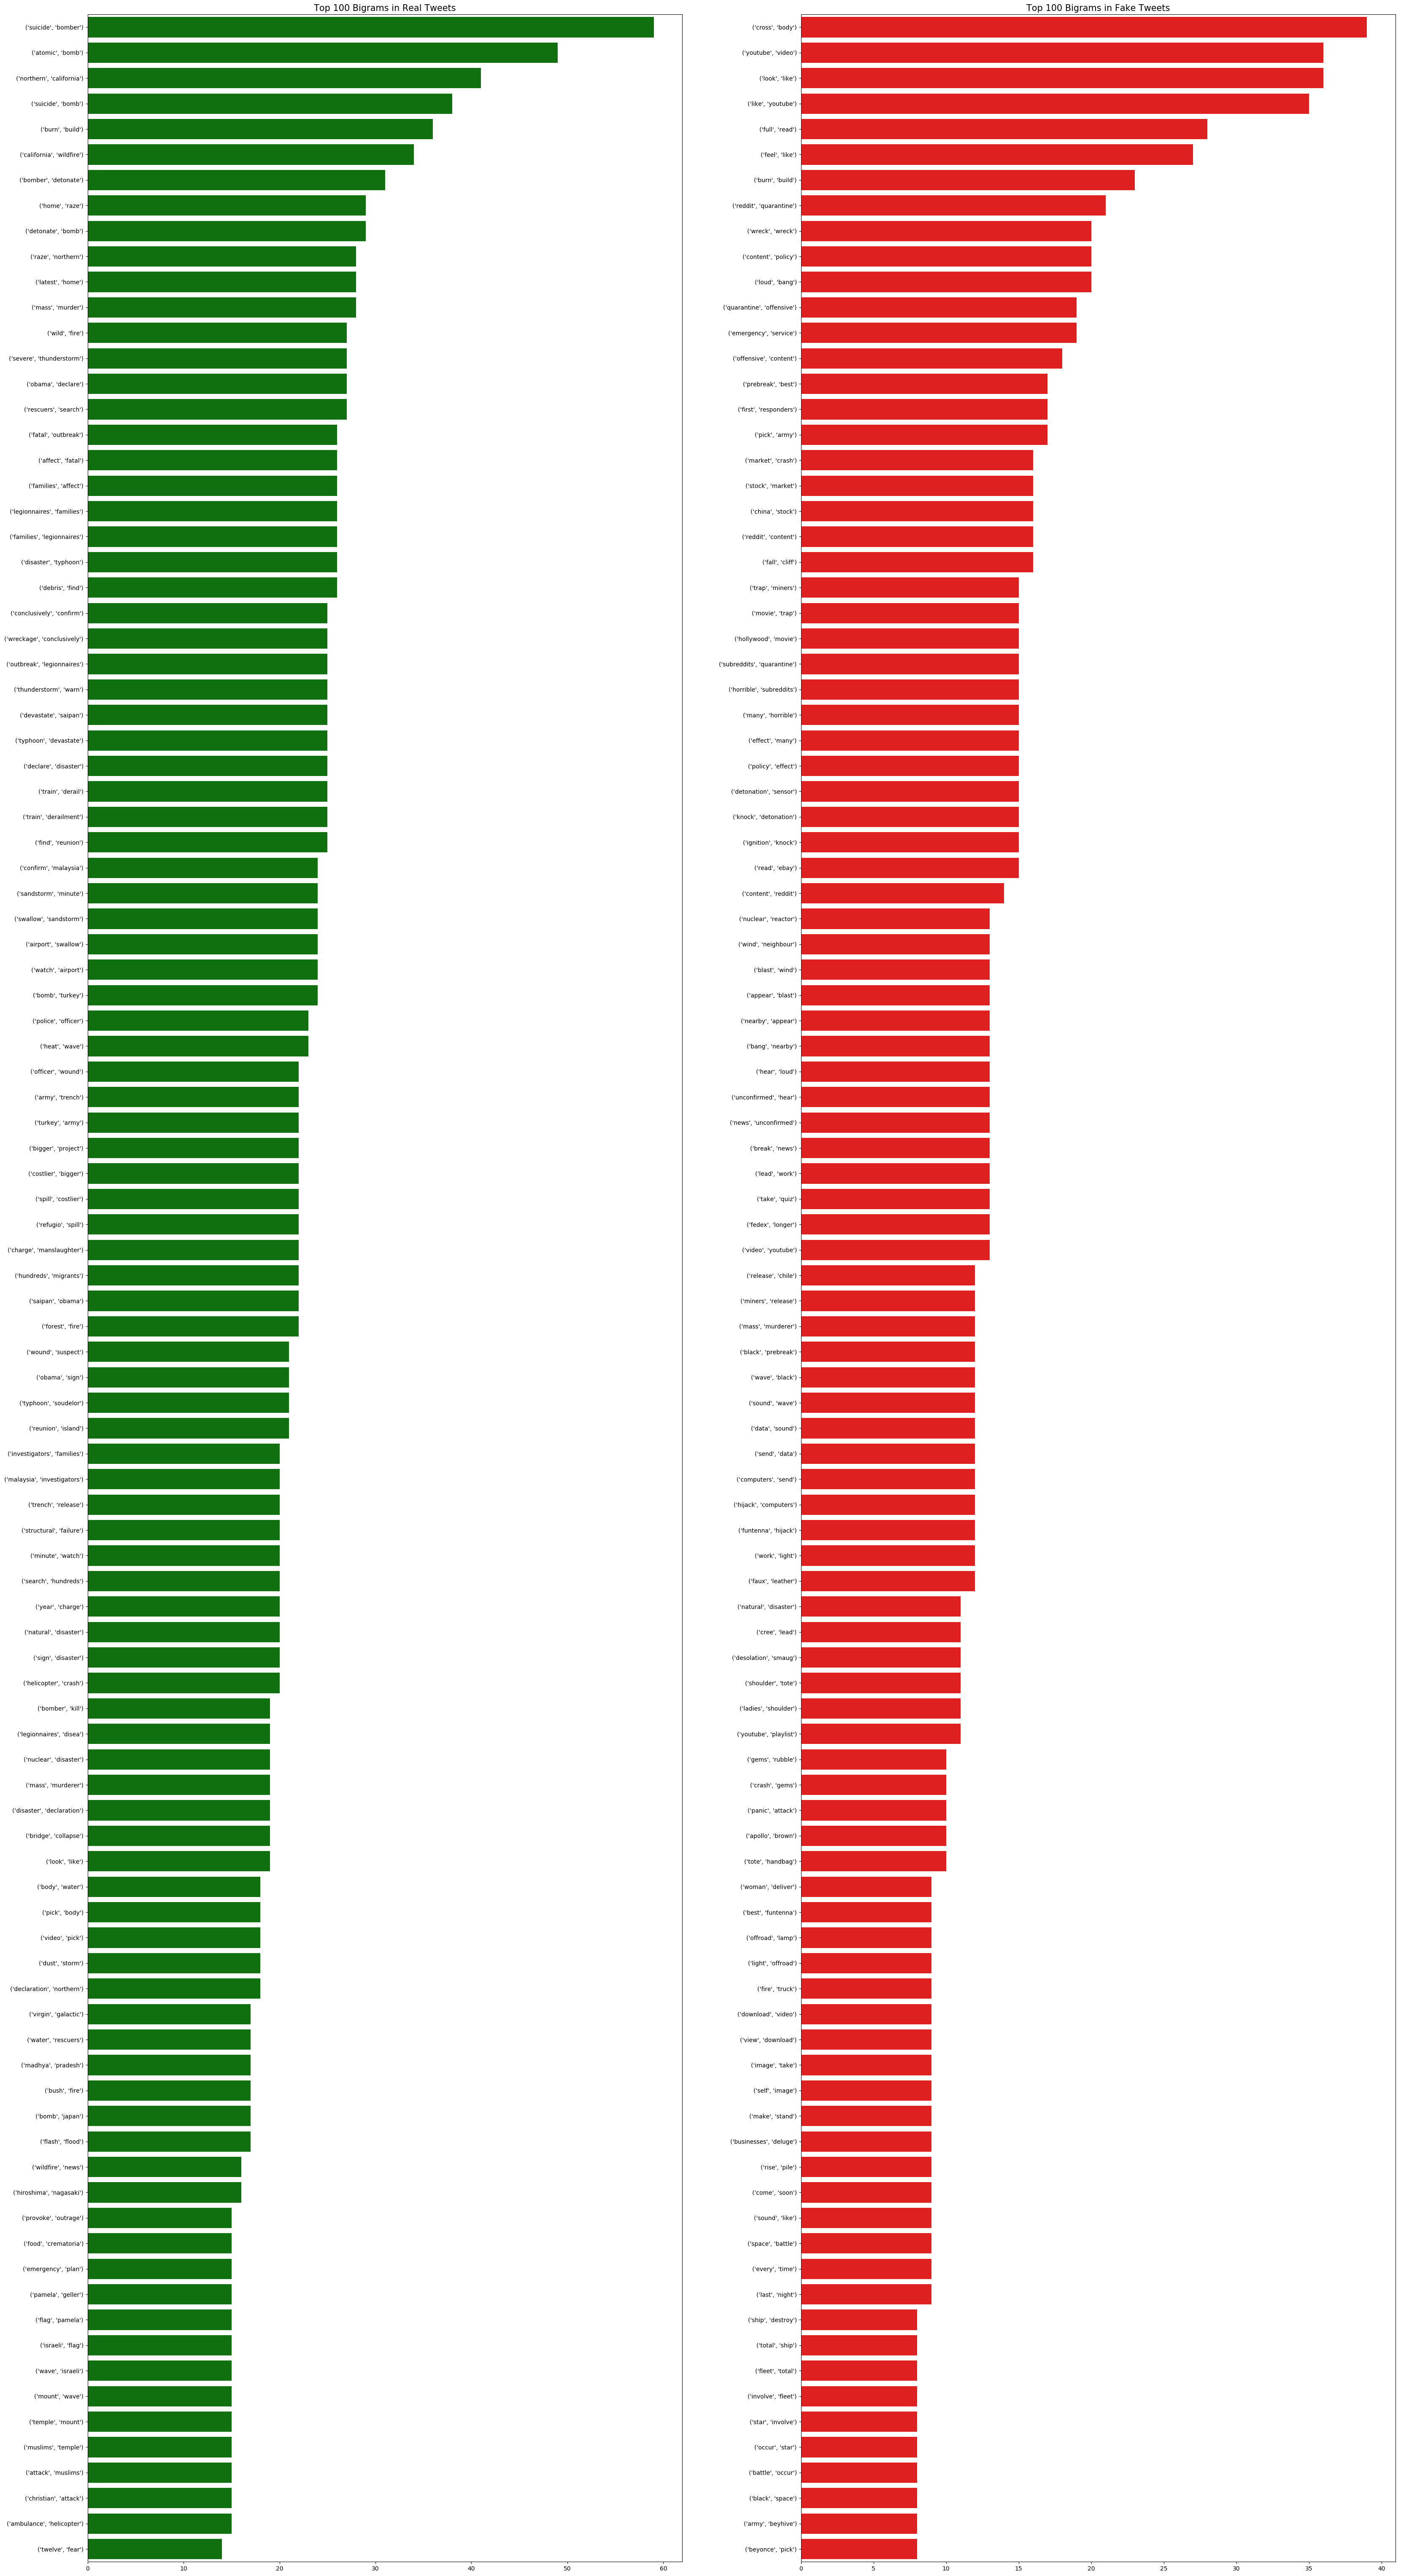

In [44]:
# lets visualize top 100 bigrams

draw_barplots(real_bigrams,fake_bigrams," Bigrams ")

### Trigrams

In [45]:
# lets create top 100 trigrams
real_trigrams = get_ngrams(real,3)
fake_trigrams = get_ngrams(fake,3)

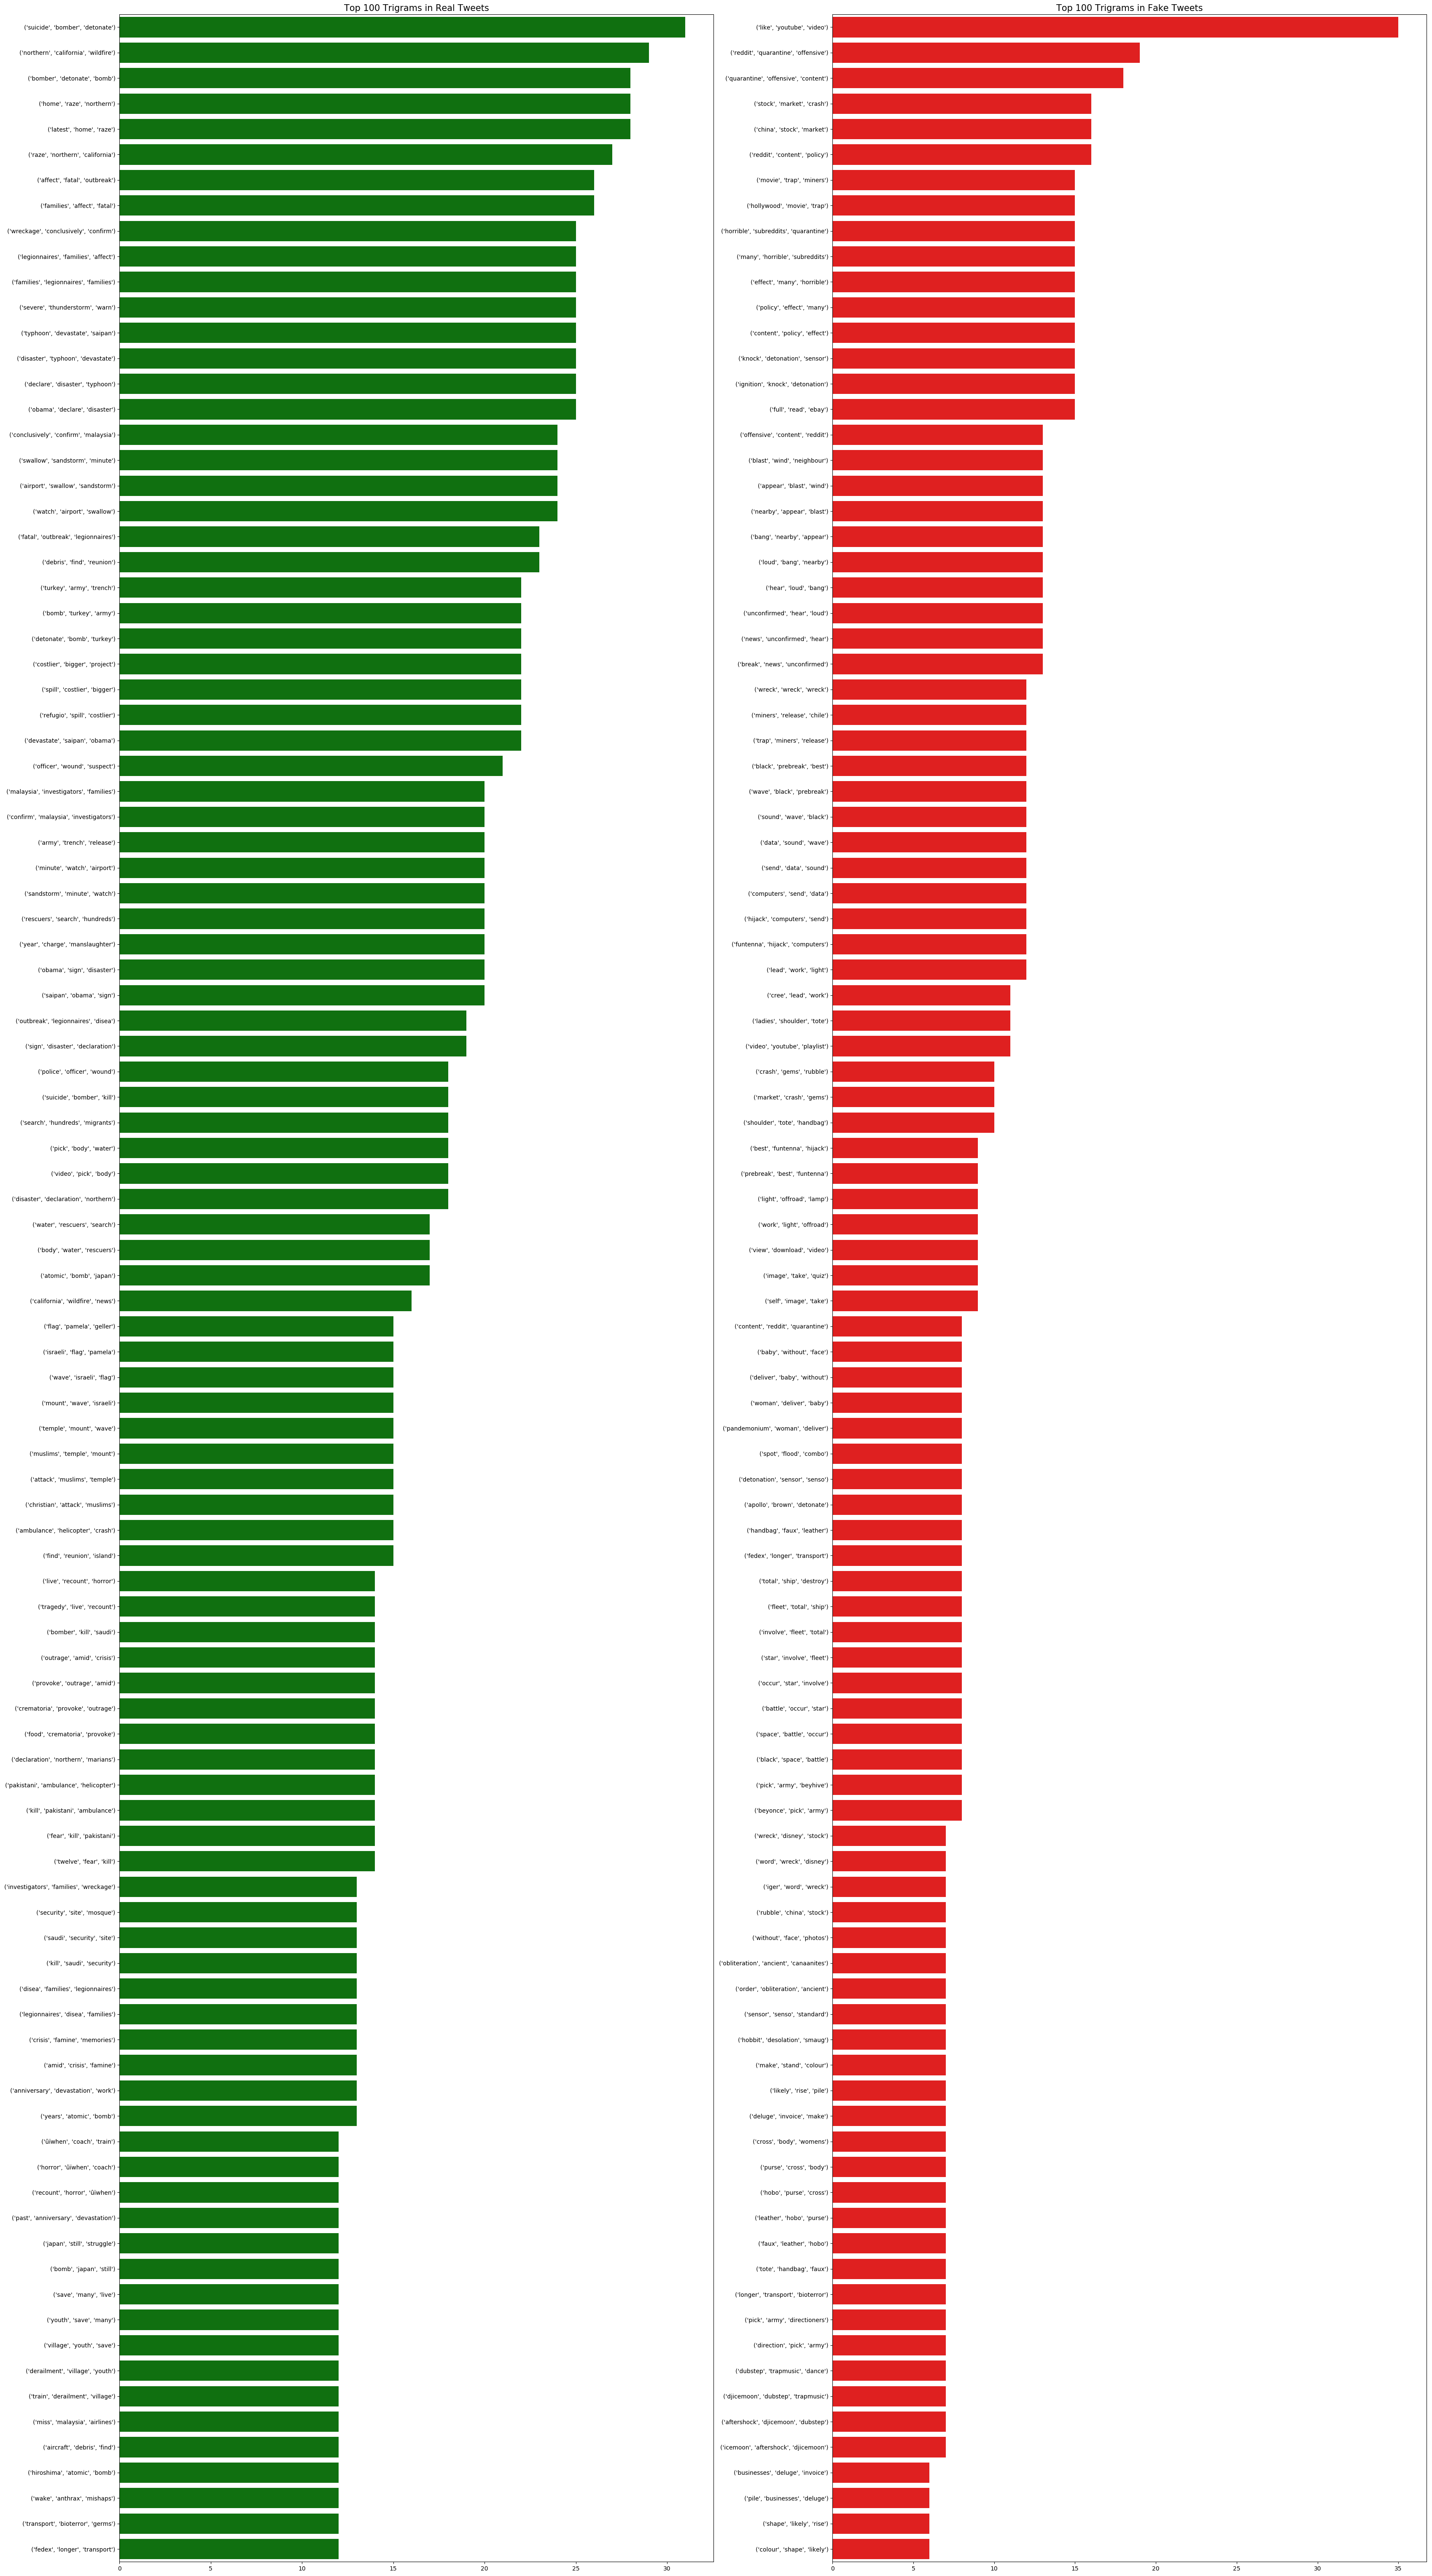

In [46]:
# lets visualize top 100 trigrams
draw_barplots(real_trigrams,fake_trigrams," Trigrams ")

# Lets plot word cloud for real and fake tweets

In [47]:
def word_cloud(df):
    comment_words = '' 
    stopwords = set(STOPWORDS) 

    # iterate through the csv file 
    for val in df.text: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 
        
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower()
        
        comment_words += " ".join(tokens)+" "
        #return comment_words

    wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwords, 
            min_font_size = 10).generate(comment_words) 
  
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 

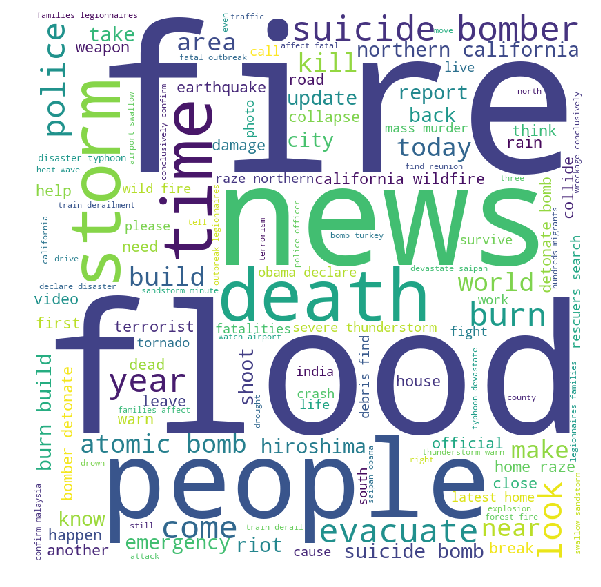

In [48]:
# world cloud for real disaster tweets
word_cloud(real)

Above world cloud image gives a good picture of the most common words used in the real disaster tweets. words like "news" "suicide" "bomber" "storm" "bomb" "kill" are used heavily in the real disaster tweets which makes complete sense.

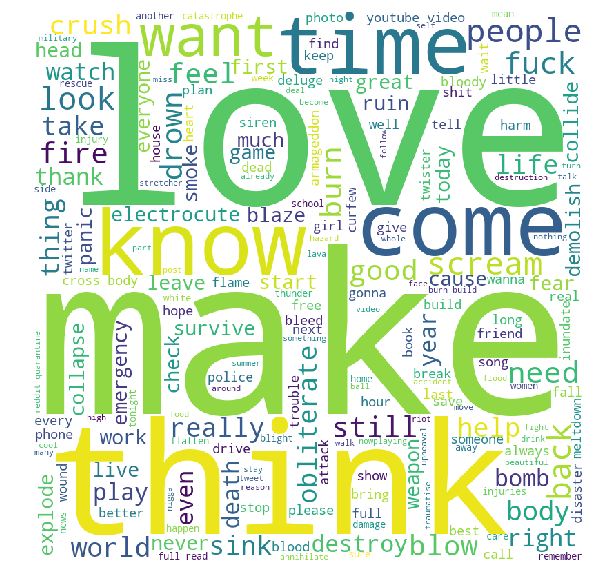

In [49]:
# world cloud for fake disaster tweets
word_cloud(fake)

Above world cloud image gives a good picture of the most common words used in the fake disaster tweets, you can clearly notice words like "love" "know" "good" etc. have very less probablity of appearning in the disaster tweets.

# Model Building & Evaluation

I will create an Artificial Neural Network, this competition is evaluated on f1 scores,which is not shown by default after every epoch, so lets create a function to  achieve the same.

In [50]:
# function to calculate f1 score for each epoch
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


In [51]:
# Bag of Words model
from keras.preprocessing.text import Tokenizer

# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [52]:
# lets use only tweet text to build the model
X = train.text
y = train.target

test_id = test.id
test.drop(["id","location","keyword"],1,inplace = True)

In [53]:
# Test train split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [54]:
# create and apply tokenizer on the training dataset
tokenizer = create_tokenizer(X_train)
X_train_set = tokenizer.texts_to_matrix(X_train, mode = 'freq')


In [55]:
# define the model
def define_model(n_words):
    # define network
    model = Sequential()
    model.add(Dense(128, input_shape=(n_words,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = [get_f1])
    # summarize defined model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [56]:
# create the model
n_words = X_train_set.shape[1]
model = define_model(n_words)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               706560    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 706,689
Trainable params: 706,689
Non-trainable params: 0
_________________________________________________________________


In [57]:
#fit network
model.fit(X_train_set,y_train,epochs=10,verbose=2)

Epoch 1/10
 - 2s - loss: 0.6258 - get_f1: 0.3176
Epoch 2/10
 - 1s - loss: 0.4400 - get_f1: 0.7737
Epoch 3/10
 - 1s - loss: 0.3433 - get_f1: 0.8289
Epoch 4/10
 - 1s - loss: 0.2879 - get_f1: 0.8567
Epoch 5/10
 - 1s - loss: 0.2473 - get_f1: 0.8804
Epoch 6/10
 - 1s - loss: 0.2174 - get_f1: 0.8993
Epoch 7/10
 - 1s - loss: 0.1926 - get_f1: 0.9122
Epoch 8/10
 - 1s - loss: 0.1728 - get_f1: 0.9250
Epoch 9/10
 - 1s - loss: 0.1553 - get_f1: 0.9312
Epoch 10/10
 - 1s - loss: 0.1420 - get_f1: 0.9370


In [58]:
# prediction on the test dataset
X_test_set = tokenizer.texts_to_matrix(X_test, mode = 'freq')
y_pred = model.predict_classes(X_test_set)

In [59]:
# important metrices
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.74      0.77       874
           1       0.68      0.75      0.71       649

    accuracy                           0.74      1523
   macro avg       0.74      0.74      0.74      1523
weighted avg       0.75      0.74      0.75      1523



In [60]:
# apply tokenizer on the test dataset
test_set = tokenizer.texts_to_matrix(test.text, mode = 'freq')

In [61]:
# make predictions on the test dataset
y_test_pred = model.predict_classes(test_set)

In [62]:
# lets prepare for the prediction submission
sub = pd.DataFrame()
sub['Id'] = test_id
sub['target'] = y_test_pred
sub.to_csv('submission_1.csv',index=False)

# GLOVE with KERAS Word Embeddings

# Word Embeddings

Word embedding methods learn a real-valued vector representation for a predefined fixed sized vocabulary from a corpus of text. The learning process is either joint with the neural network model on some task, such as document classification, or is an unsupervised process, using document statistics.

There are basically 3 methods that can be used to learn a word embedding from text data. Methods are as follows:

**1. Embedding layer**  
An embedding layer, is a word embedding that is learned jointly with a neural network model on a specific natural language processing task,It requires that document text be cleaned and prepared such that each word is one hot encoded. The size of the vector space is specified as part of the model, such as 50, 100, or 300 dimensions. The vectors are initialized with small random numbers. The embedding layer is used on the front end of a neural network and is fit in a
supervised way using the Backpropagation algorithm.

**2. Word2Vec**
Word2Vec is a statistical method for eficiently learning a standalone word embedding from a text corpus. It was developed by Tomas Mikolov, et al. at Google in 2013 as a response to make the neural-network-based training of the embedding more eficient and since then has become the de facto standard for developing pre-trained word embedding.
Two different learning models were introduced that can be used as part of the Word2Vec
approach to learn the word embedding; they are:

    2.1 Continuous Bag-of-Words, or CBOW mode
          The CBOW model learns the embedding by predicting the current word based on its context.
          
    2.2 Continuous Skip-Gram Model
          The continuous skip-gram model learns by predicting the surrounding words given a current word.

**3. GLOVE**
The Global Vectors for Word Representation, or GloVe, algorithm is an extension to the Word2Vec method for efficiently learning word vectors, developed by Pennington, et al. at Stanford. Classical vector space model representations of words were developed using matrix factorization techniques such as Latent Semantic Analysis (LSA) that do a good job of using global text statistics but are not as good as the learned methods like Word2Vec at capturing meaning and demonstrating it on tasks like calculating analogies.


In [63]:
# Fitting a tokenizer on text will create a list of unique words with an integer assigned to it
t = Tokenizer()
t.fit_on_texts(X_train.tolist())

In [64]:
# lets save the size of the vocab
vocab_size = len(t.word_index) + 1

In [65]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('../input/glove6b100dtxt/glove.6B.100d.txt', mode='rt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [66]:
# we will now perform the encoding
encoded_docs = t.texts_to_sequences(X_train.tolist())

# embedding layer require all the encoded sequences to be of the same length, lets take max lenght as 100
# and apply padding on the sequences which are of lower size
max_length = 100
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[2761 1750   51 ...    0    0    0]
 [1076 1751 2154 ...    0    0    0]
 [ 156 2155 2763 ...    0    0    0]
 ...
 [1274  213 1165 ...    0    0    0]
 [ 405  102  325 ...    0    0    0]
 [ 219 1147  859 ...    0    0    0]]


In [67]:
# create a weight matrix for words in training docs
mis_spelled = []
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        mis_spelled.append(word)

In [68]:
# lets check how many words are not spelled correctly 
len(mis_spelled)

547

In [69]:
# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=100, trainable=False)
model.add(e)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[get_f1])
# summarize the model
model.summary()
# fit the model
model.fit(padded_docs, y_train, epochs=50, verbose=0)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          551900    
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 10001     
Total params: 561,901
Trainable params: 10,001
Non-trainable params: 551,900
_________________________________________________________________


In [70]:
loss, accuracy = model.evaluate(padded_docs, y_train, verbose=0)

In [71]:
print(accuracy)

0.8206408619880676


In [72]:
encoded_docs = t.texts_to_sequences(X_test.tolist())
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [73]:
# prediction on the test dataset
y_pred = model.predict_classes(padded_docs)

In [74]:
encoded_docs = t.texts_to_sequences(test.text.tolist())
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [75]:
y_test_pred = model.predict_classes(padded_docs)

In [76]:
# lets prepare for the prediction submission
sub = pd.DataFrame()
sub['Id'] = test_id
sub['target'] = y_test_pred
sub.to_csv('submission_2.csv',index=False)

# CNN with word Embeddings

In [77]:
# fit a tokenizer
#we have already fit a tokenizer on our data, pasting the same code again
#t = Tokenizer()
#t.fit_on_texts(X_train.tolist())

Now that the mapping of words to integers has been prepared, we can use it to encode the tweets in the training dataset. We can do that by calling the texts to sequences() function on the Tokenizer. We also need to ensure that all documents have the same length. This is a
requirement of Keras for eficient computation. 

We could truncate tweets to the smallest size or zero-pad (pad with the value 0) tweets to the maximum length, or some hybrid. In this case,we will pad all tweets to the length of the longest tweet in the training dataset. First, we can find the longest review using the max() function on the training dataset and take its length.

We can then call the Keras function pad sequences() to pad the sequences to the maximum length by adding 0 values on the end.

In [78]:
max_length = max([len(s) for s in train.text])
print('Maximum length: %d' % max_length)

Maximum length: 121


We can then use the maximum length as a parameter to a function to integer encode and pad the sequences.

In [79]:
# we will now perform the encoding
encoded_docs = t.texts_to_sequences(X_train.tolist())

# embedding layer require all the encoded sequences to be of the same length, lets take max lenght as 100
# and apply padding on the sequences which are of lower size

padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[2761 1750   51 ...    0    0    0]
 [1076 1751 2154 ...    0    0    0]
 [ 156 2155 2763 ...    0    0    0]
 ...
 [1274  213 1165 ...    0    0    0]
 [ 405  102  325 ...    0    0    0]
 [ 219 1147  859 ...    0    0    0]]


We are now ready to define our neural network model. The model will use an Embedding layer as the first hidden layer. The Embedding layer requires the specification of the vocabulary size, the size of the real-valued vector space, and the maximum length of input documents. 

The vocabulary size is the total number of words in our vocabulary, plus one for unknown words. This could be the vocab set length or the size of the vocab within the tokenizer used to integer encode the documents, for example:

In [80]:
# define vocabulary size
#  we laready have vocab size
vocab_size

5519

We will use a 100-dimensional vector space.

Finally, the maximum document length was calculated above in the max length variable used during padding.

We use a Convolutional Neural Network (CNN) as they have proven to be successful at document classification problems. A conservative CNN configuration is used with 32 filters (parallel fields for processing words) and a kernel size of 8 with a rectified linear (relu) activation function. This is followed by a pooling layer that reduces the output of the convolutional layer by half.

Next, the 2D output from the CNN part of the model is attened to one long 2D vector to represent the features extracted by the CNN. The back-end of the model is a standard Multilayer Perceptron layers to interpret the CNN features. The output layer uses a sigmoid activation
function to output a value between 0 and 1 for the negative and positive sentiment in the review.

Next, we fit the network on the training data. We use a binary cross entropy loss function because the problem we are learning is a binary classification problem. The eficient Adam implementation of stochastic gradient descent is used and we keep track of accuracy in addition
to loss during training. The model is trained for 10 epochs, or 10 passes through the training data. The network configuration and training schedule were found with a little trial and error,but are by no means optimal for this problem.

In [81]:
# define the model
def define_model(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=max_length))
    model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize defined model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [82]:
# define model
model = define_model(vocab_size, max_length)
# fit network
model.fit(padded_docs, y_train, epochs=10, verbose=2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 121, 100)          551900    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 114, 32)           25632     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 57, 32)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1824)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                18250     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 595,793
Trainable params: 595,793
Non-trainable params: 0
________________________________________________

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
 - 4s - loss: 0.5850 - accuracy: 0.6833
Epoch 2/10
 - 1s - loss: 0.3575 - accuracy: 0.8553
Epoch 3/10
 - 1s - loss: 0.2490 - accuracy: 0.9069
Epoch 4/10
 - 1s - loss: 0.1621 - accuracy: 0.9452
Epoch 5/10
 - 1s - loss: 0.1145 - accuracy: 0.9591
Epoch 6/10
 - 1s - loss: 0.0887 - accuracy: 0.9683
Epoch 7/10
 - 1s - loss: 0.0766 - accuracy: 0.9685
Epoch 8/10
 - 1s - loss: 0.0645 - accuracy: 0.9722
Epoch 9/10
 - 1s - loss: 0.0601 - accuracy: 0.9749
Epoch 10/10
 - 1s - loss: 0.0536 - accuracy: 0.9757


In [83]:
loss, accuracy = model.evaluate(padded_docs, y_train, verbose=0)

In [84]:
print(accuracy)

0.9794745445251465


In [85]:
encoded_docs = t.texts_to_sequences(X_test.tolist())
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [86]:
# prediction on the test dataset
y_pred = model.predict_classes(padded_docs)

In [87]:
encoded_docs = t.texts_to_sequences(test.text.tolist())
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [88]:
y_test_pred = model.predict_classes(padded_docs)

In [89]:
# lets prepare for the prediction submission
sub = pd.DataFrame()
sub['Id'] = test_id
sub['target'] = y_test_pred
sub.to_csv('submission_cnn.csv',index=False)

In [90]:
# save the model
model.save('model.h5')

# Multi Channel n-gram CNN Model

In [91]:
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.models import Model
# define the model 
def define_model(length, vocab_size): 
    # channel 1 
    inputs1 = Input(shape=(length,)) 
    embedding1 = Embedding(vocab_size, 100)(inputs1) 
    conv1 = Conv1D(32, 4, activation='relu')(embedding1) 
    drop1 = Dropout(0.5)(conv1) 
    pool1 = MaxPooling1D()(drop1) 
    flat1 = Flatten()(pool1)
    
    # channel 2 
    inputs2 = Input(shape=(length,)) 
    embedding2 = Embedding(vocab_size, 100)(inputs2) 
    conv2 = Conv1D(32, 6, activation='relu')(embedding2) 
    drop2 = Dropout(0.5)(conv2) 
    pool2 = MaxPooling1D()(drop2) 
    flat2 = Flatten()(pool2) 
    
    # channel 3 
    inputs3 = Input(shape=(length,)) 
    embedding3 = Embedding(vocab_size, 100)(inputs3) 
    conv3 = Conv1D(32, 8, activation='relu')(embedding3) 
    drop3 = Dropout(0.5)(conv3) 
    pool3 = MaxPooling1D()(drop3) 
    flat3 = Flatten()(pool3)
    
    # merge 
    merged = concatenate([flat1, flat2, flat3]) 
    # interpretation 
    dense1 = Dense(10, activation='relu')(merged) 
    outputs = Dense(1, activation='sigmoid')(dense1) 
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs) 
    # compile 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
    # summarize 
    model.summary() 
    plot_model(model, show_shapes=True, to_file='multichannel.png') 
    return model


Now we will develop a multi-channel convolutional neural network for the Tweet analysis prediction problem:

1. Encode Data
2. Deﬁne Model.
3. Fit the model on the given data.
4. Make predictions on test data.

A standard model for document classiﬁcation is to use an Embedding layer as input, followed by a one-dimensional convolutional neural network, pooling layer, and then a prediction output layer. The kernel size in the convolutional layer deﬁnes the number of words to consider as  the convolution is passed across the input text document, providing a grouping parameter. 

A multi-channel convolutional neural network for document classiﬁcation involves using multiple versions of the standard model with diﬀerent sized kernels. This allows the document to be processed at diﬀerent resolutions or diﬀerent n-grams (groups of words) at a time, whilst the model learns how to best integrate these interpretations. 

We will deﬁne a model with three input channels for processing 4-grams, 6-grams, and 8-grams of movie review text. Each channel is comprised of the following elements:
*  Input layer that deﬁnes the length of input sequences.
*  Embedding layer set to the size of the vocabulary and 100-dimensional real-valued representations.
*  Conv1D layer with 32 ﬁlters and a kernel size set to the number of words to read at once.
*  MaxPooling1D layer to consolidate the output from the convolutional layer.
*  Flatten layer to reduce the three-dimensional output to two dimensional for concatenation.

The output from the three channels are concatenated into a single vector and process by a Dense layer and an output layer. The function below deﬁnes and returns the model. As part of deﬁning the model, a summary of the deﬁned model is printed and a plot of the model graph is created and saved to ﬁle.


In [92]:
# we will now perform the encoding
encoded_docs = t.texts_to_sequences(X_train.tolist())

# embedding layer require all the encoded sequences to be of the same length, lets take max lenght as 100
# and apply padding on the sequences which are of lower size

padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')


In [93]:
# define model
model = define_model(max_length,vocab_size)
# fit network
model.fit([padded_docs,padded_docs,padded_docs], array(y_train), epochs=7, batch_size=16)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 121)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 121)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 121)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 121, 100)     551900      input_1[0][0]                    
____________________________________________________________________________________________

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/7
6090/6090 [==============================] - 4s 624us/step - loss: 0.5375 - accuracy: 0.7268
Epoch 2/7
6090/6090 [==============================] - 3s 478us/step - loss: 0.3255 - accuracy: 0.8703
Epoch 3/7
6090/6090 [==============================] - 3s 439us/step - loss: 0.1956 - accuracy: 0.9259
Epoch 4/7
6090/6090 [==============================] - 3s 413us/step - loss: 0.1170 - accuracy: 0.9562
Epoch 5/7
6090/6090 [==============================] - 3s 419us/step - loss: 0.0817 - accuracy: 0.9686
Epoch 6/7
6090/6090 [==============================] - 3s 469us/step - loss: 0.0678 - accuracy: 0.9696
Epoch 7/7
6090/6090 [==============================] - 3s 420us/step - loss: 0.0590 - accuracy: 0.9750


In [94]:
loss, accuracy = model.evaluate([padded_docs,padded_docs,padded_docs], y_train, verbose=0)

In [95]:
print(accuracy)

0.9798029661178589


In [96]:
encoded_docs = t.texts_to_sequences(X_test.tolist())
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [97]:
# prediction on the test dataset
_, acc = model.evaluate([padded_docs,padded_docs,padded_docs], array(y_test), verbose=0) 
print('Train Accuracy: %.2f' % (acc*100)) 

Train Accuracy: 74.33


In [98]:
encoded_docs = t.texts_to_sequences(test.text.tolist())
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [99]:
y_test_pred = model.predict([padded_docs,padded_docs,padded_docs])

In [100]:
# lets prepare for the prediction submission
sub = pd.DataFrame()
sub['Id'] = test_id
sub['target'] = y_test_pred
sub.to_csv('submission_multi-cnn.csv',index=False)

# BERT - The Concept
Most of the theoritical contents in this notebook are taken from this amazing notebook: https://www.kaggle.com/abhinand05/bert-for-humans-tutorial-baseline-version-2

# Few key points

* BERT is a deep learning model that has given state-of-the-art results on a wide variety of natural language processing tasks. It stands for Bidirectional Encoder Representations for Transformers. It has been pre-trained on Wikipedia and BooksCorpus and requires (only) task-specific fine-tuning.
  
* BERT is basically a bunch of Transformer encoders stacked together (not the whole Transformer architecture but just the encoder). The concept of bidirectionality is the key differentiator between BERT and its predecessor, OpenAI GPT. BERT is bidirectional because its self-attention layer performs self-attention on both directions.
 
* BERT is pre-trained on a large corpus of unlabelled text including the entire Wikipedia(that’s 2,500 million words!) and Book Corpus (800 million words). This pretraining step is really important for BERT's success. This is because as we train a model on a large text corpus, our model starts to pick up the deeper and intimate understandings of how the language works.

* BERT is a deeply bidirectional model. Bidirectional means that BERT learns information from both the left and the right side of a token’s context during the training phase.This bidirectional understanding is crucial to take NLP models to the next level.

* Finally the biggest advantage of BERT is it brought about the ImageNet movement with it and the most impressive aspect of BERT is that we can fine-tune it by adding just a couple of additional output layers to create state-of-the-art models for a variety of NLP tasks.


## Architecture of BERT

BERT is a multi-layer bidirectional Transformer encoder. There are two models introduced in the paper.

BERT base – 12 layers (transformer blocks), 12 attention heads, and 110 million parameters.
BERT Large – 24 layers, 16 attention heads and, 340 million parameters.

Here's a representation of BERT Architecture

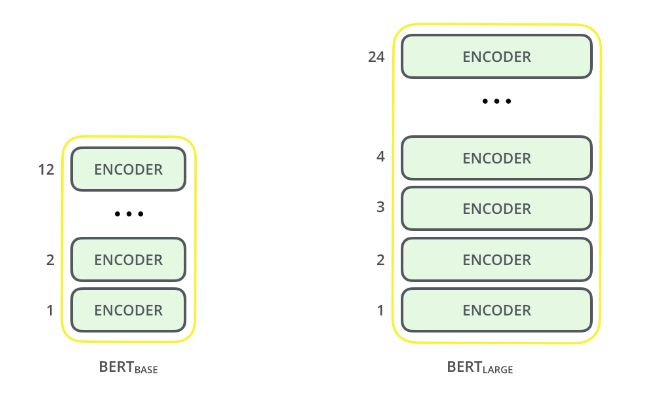

## Preprocessing Text for BERT

The input representation used by BERT is able to represent a single text sentence as well as a pair of sentences (eg., Question, Answering) in a single sequence of tokens.

* The first token of every input sequence is the special classification token – [CLS]. This token is used in classification tasks as an aggregate of the entire sequence representation. It is ignored in non-classification tasks.
* For single text sentence tasks, this [CLS] token is followed by the WordPiece tokens and the separator token – [SEP].

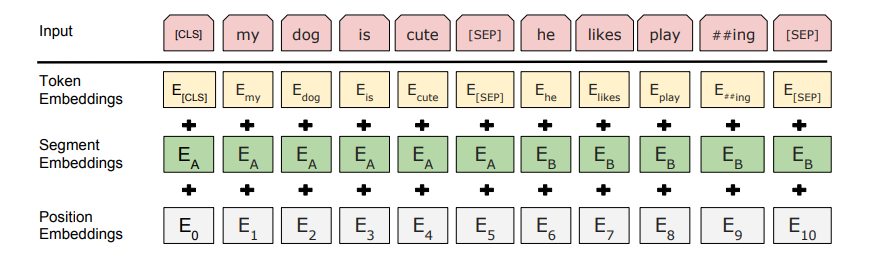


* BERT developers have set a a specific set of rules to represent languages before feeding into the model.


For starters, every input embedding is a combination of 3 embeddings:

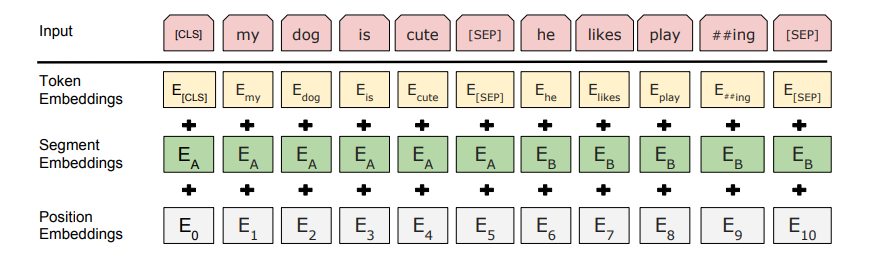

*     Position Embeddings: BERT learns and uses positional embeddings to express the position of words in a sentence. These are added to overcome the limitation of Transformer which, unlike an RNN, is not able to capture “sequence” or “order” information

*     Segment Embeddings: BERT can also take sentence pairs as inputs for tasks (Question-Answering). That’s why it learns a unique embedding for the first and the second sentences to help the model distinguish between them. In the above example, all the tokens marked as EA belong to sentence A (and similarly for EB)
 
*     Token Embeddings: These are the embeddings learned for the specific token from the WordPiece token vocabulary
For a given token, its input representation is constructed by summing the corresponding token, segment, and position embeddings.


* Tokenization: BERT uses WordPiece tokenization. The vocabulary is initialized with all the individual characters in the language, and then the most frequent/likely combinations of the existing words in the vocabulary are iteratively added.

# Code Implementation in Tensorflow 2.0

In [101]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [102]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

import tokenization

# Re-loading input files, BERTS seems to do better on raw data

In [103]:
# load train and test datasets
train= pd.read_csv('../input/nlp-getting-started/train.csv')
test=pd.read_csv('../input/nlp-getting-started/test.csv')

In [104]:
### Add tokens to the data make it BERT compatible
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [105]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [106]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 1min 21s, sys: 5.87 s, total: 1min 27s
Wall time: 1min 27s


In [107]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [108]:
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)


In [109]:
train_input = bert_encode(train.text.values, tokenizer, max_len=160)
test_input = bert_encode(test.text.values, tokenizer, max_len=160)
train_labels = train.target.values

In [110]:
model = build_model(bert_layer, max_len=160)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [111]:
train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=3,
    batch_size=16
)

Train on 6090 samples, validate on 1523 samples
Epoch 1/3
6090/6090 [==============================] - 416s 68ms/sample - loss: 0.4846 - accuracy: 0.7796 - val_loss: 0.4076 - val_accuracy: 0.8201
Epoch 2/3
6090/6090 [==============================] - 374s 61ms/sample - loss: 0.3632 - accuracy: 0.8498 - val_loss: 0.4007 - val_accuracy: 0.8267
Epoch 3/3
6090/6090 [==============================] - 374s 61ms/sample - loss: 0.2865 - accuracy: 0.8824 - val_loss: 0.4053 - val_accuracy: 0.8286


In [112]:
test_pred = model.predict(test_input)

In [113]:
submission=pd.DataFrame()
submission['Id']=test_id
submission['target'] = test_pred.round().astype(int)
submission.to_csv('submission_3.csv', index=False)


# Kindly upvote if you like my work :)